In [155]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
import random
import math
from pprint import pprint
import seaborn as sns
from sklearn import metrics

In [156]:
#confusion matrix plotting
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [157]:
def plot_model_report(y_test,y_pred):
    # Generate a classification report
    cm_plot_labels = ['Not Spam', 'Spam']
    # For this to work we need y_pred as binary labels not as probabilities
    #y_pred_binary = np.where(predictions > 0.5, 1, 0)

    report = classification_report(y_test, y_pred, target_names=cm_plot_labels)

    print(report)

    # argmax returns the index of the max value in a row
    cm = confusion_matrix(y_test, y_pred)

    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [158]:
# Create a leaf node value based on majority vote
def to_terminal(outcomes,w):
    class_values = np.unique(outcomes)
    total_weight=np.sum(w)
    tup=[(np.sum(w[outcomes==class_val]) / total_weight,class_val) for class_val in class_values]
    return sorted(tup, key = lambda x: x[0], reverse=True)[0][1]


In [160]:
#This gives best split node for decision tree uisng gini impurity
def find_split(X_train, y_train,w):
    class_values = np.unique(y_train)
    X,Y=X_train,y_train
    #parameter initialization
    min_gini=999 
    z=999
    col=999
    gini_total=0
    best_tree_childs=()
    best_weights=()
    #for each column
    for j in range(X_train.shape[-1]):
        #indices=np.argsort(X_train[:, j])
        #X,Y=X_train[indices],y_train[indices]
        #if we take unique value for j-th column into account then it reduces the time computation instead of individual value
        unique_values_to_split=np.unique(X[:,j])
        #for each unique value of j-th column 
        for i in unique_values_to_split:
            curr_z=i
            #splitted data based on current value of j-th column
            y_left,y_right=Y[X[:, j] < curr_z],Y[X[:, j] >= curr_z]
            #sample weights for left child and right child
            w1,w2=w[X[:, j] < curr_z],w[X[:, j] >= curr_z]
            childs=(y_left,y_right)
            weights=(w1,w2)
            #weighted average gini impurity value for both groups left and right child
            gini=gini_index(childs, weights, class_values)
            #print(j,i,gini)
            #best gini value which is minimum among all values
            if min_gini>gini:
                min_gini=gini
                z=curr_z
                col=j
                best_tree_childs=childs
                best_weights=weights
    #parent node gini impuirty calculation with sample weights
    for class_val in class_values:
        p = np.sum(w[y_train==class_val]) / np.sum(w)
        gini_total += p * p
    gini_parent=1-gini_total
    #gini gain if we split parent into left child and right child which is basically will be used to calculate feature importance
    gini_gain=(gini_parent-min_gini)*np.sum(w)
    #print('X'+str(j_temp)+' cutoff: '+str(z))
    return z,col,gini_gain,best_tree_childs,best_weights

In [161]:
# Calculate the Gini index for a split dataset
def gini_index(childs, weights ,classes):
    # count all samples with their weight at split point
    n_instances = np.sum(np.concatenate(weights))
    # sum weighted Gini index for each childs
    gini=0
    for child_node,weight in zip(childs,weights):
        size = np.sum(weight)
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = np.sum(weight[child_node==class_val]) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

In [163]:
class DecisionTreeClassifier():
    #initialiazation with math depth(max_depth) and minimum no of asmples for leaf(t)
    def __init__(self, max_depth=5,t=1):
        self.max_depth = max_depth
        self.t=t
    #fit method with parameters dataset, parent node information and depth of the tree
    def fit(self, x, y, par_node={}, depth=0, w=None):
            t=self.t
            cutoff,col, gini_gain,best_tree_childs,best_weights = find_split(x, y, w)    # find best split given a gini impurity 
            #best split information assignment for tree node
            par_node = {'col': 'X'+str(col), 'index_col':col,'cutoff':cutoff,'gini_gain':gini_gain }
            y_left,y_right=best_tree_childs
            w1,w2=best_weights
            #print('y_left:',y_left.size,' y_right ',y_right.size)
            #if any of the child samples are zero then there is no need of further split 
            if y_left.size==0 or y_right.size==0:
                par_node['left'] = par_node['right'] = to_terminal(np.array(list(y_left) + list(y_right)),np.array(list(w1) + list(w2)))
                return par_node
            # trif ee depth is greater than equals to max depth then we can stop here
            if depth >= self.max_depth:
                par_node['left'], par_node['right'] = to_terminal(y_left,w1), to_terminal(y_right,w2)
                return par_node
            #stop if leaf nodes have less samples than the specified value otherwise split further
            if y_left.size<=t:
                par_node['left']=to_terminal(y_left,w1)
            else:
                par_node['left'] = self.fit(x[x[:, col] < cutoff], y_left, {}, depth+1,w1)
            
            if y_right.size<=t:
                par_node['right']=to_terminal(y_right,w2)
            else:
                par_node['right'] = self.fit(x[x[:, col] >= cutoff], y_right, {}, depth+1,w2) 
            self.trees = par_node
            return par_node

In [164]:
#prediction using trained parameters of tree
def predict( m,x):
    tree = m
    results = np.array([0]*len(x))
    for i, c in enumerate(x):
        results[i] = get_prediction(m,c)
    return results
    
def get_prediction(m, row):
    cur_layer = m
    while cur_layer['cutoff'] is not None:
        if row[cur_layer['index_col']] <= cur_layer['cutoff']:
            if isinstance(cur_layer['left'], dict):
                cur_layer = cur_layer['left']
            else:
                return cur_layer['left']
        else:
            if isinstance(cur_layer['right'], dict):
                cur_layer = cur_layer['right']
            else:
                return cur_layer['right']
        #print('cutoff',cur_layer['cutoff'])


In [165]:
class Adaboost():

    def __init__(self, n_clf=5,max_depth=1):
        self.n_clf = n_clf
        self.max_depth=max_depth

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionTreeClassifier(max_depth=self.max_depth).fit(X,y,w=w)
            # calculate predictions
            predictions=predict(clf,X)
            # Error = sum of weights of misclassified samples
            misclassified = w[y != predictions]
            error = sum(misclassified)

            # calculate alpha
            EPS = 1e-10
            alpha = 0.5 * np.log((1.0 - error + EPS) / (error + EPS))


            w *= np.exp(-alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append((clf,alpha))

    def predict(self, X):
        clf_preds = [clf[1] * predict(clf[0],X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

In [166]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

data = np.array(pd.read_csv('spambase.data', header=None))
feature_names=['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total']

X = data[:,:-1] # features
y = data[:,-1] # Last column is label
y[y == 0] = -1  #converted class label 0 as -1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
n_clf=150
# Adaboost classification with  weak classifiers with tree depth=1
clf = Adaboost(n_clf=150,max_depth=1)
#adaboost fit method call
clf.fit(X_train, y_train)
#prediction on unseen data using the adaboost trained model
y_pred = clf.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
#AUC function call
print('AUC',metrics.auc(fpr, tpr))
#F1-score calculation
print('F1-score',metrics.f1_score(y_test, y_pred))
#accuracy calculation
acc = accuracy(y_test, y_pred)
print ("Accuracy:", acc)

AUC 0.9366348328725811
F1-score 0.9206349206349206
Accuracy: 0.9402823018458197


# a) Print a confusion matrix.


              precision    recall  f1-score   support

    Not Spam       0.95      0.95      0.95       575
        Spam       0.92      0.92      0.92       346

    accuracy                           0.94       921
   macro avg       0.94      0.94      0.94       921
weighted avg       0.94      0.94      0.94       921

Confusion matrix, without normalization
[[547  28]
 [ 27 319]]


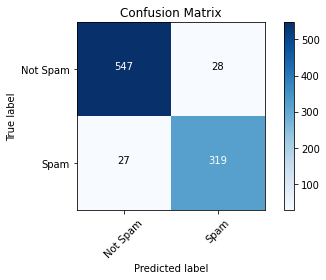

In [167]:
plot_model_report(y_test,y_pred) #ada boost model with decision tree max depth=1 report plotting

# (b) Is AdaBoost better when using stronger weak learners? Why or why not? Compare your results to using depth-2 decision trees.

Answer:No, adaboost is not better when using stronger weak learners.
The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction.
Because of the above procedure, the boosted algorithms can learn so well that it beats the decision trees or ensembles of decision trees like RandomForest in almost all the cases.
So, boosting is a learning algorithm, which can generate high-accuracy predictions using as a subroutine another algorithm, which in turn can efficiently generate hypotheses just slightly better (by an inverse polynomial) than random guessing.

It's main advantage is speed.
According to ROBERT E. SCHAPIRE( https://www.cs.princeton.edu/~schapire/papers/strengthofweak.pdf ) the "strong" and "weak" learning are equivalent.
And perhaps the answer  the original question is, "there's no point constructing strong learners when you can construct weak ones more cheaply".

In [168]:
# Adaboost classification with  tree depth=2
clf2 = Adaboost(n_clf=150,max_depth=2)
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print('AUC',metrics.auc(fpr, tpr))
print('F1-score',metrics.f1_score(y_test, y_pred))
acc = accuracy(y_test, y_pred)
print ("Accuracy:", acc)

AUC 0.9331565720030159
F1-score 0.9153515064562411
Accuracy: 0.9359391965255157


In [172]:
def temp_pred(X,clfs):
    clf_preds = [clf[1] * predict(clf[0],X) for clf in clfs]
    y_pred = np.sum(clf_preds, axis=0)
    y_pred = np.sign(y_pred)
    return y_pred
    

In [174]:
test_f1_m1=[]
test_f1_m2=[]
test_auc_m1=[]
test_auc_m2=[]
test_acc_m1=[]
test_acc_m2=[]
for i in range(n_clf):
    #test set adaboost model with tree depth 1 prediction
    y_pred=temp_pred(X_test,clf.clfs[:i+1])
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    test_auc_m1.append(metrics.auc(fpr, tpr))
    test_f1_m1.append(metrics.f1_score(y_test, y_pred))
    test_acc_m1.append(accuracy(y_test, y_pred))
    
    #test set adaboost model with tree depth 2 prediction
    y_pred=temp_pred(X_test,clf2.clfs[:i+1])
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    test_auc_m2.append(metrics.auc(fpr, tpr))
    test_f1_m2.append(metrics.f1_score(y_test, y_pred))
    test_acc_m2.append(accuracy(y_test, y_pred))
    

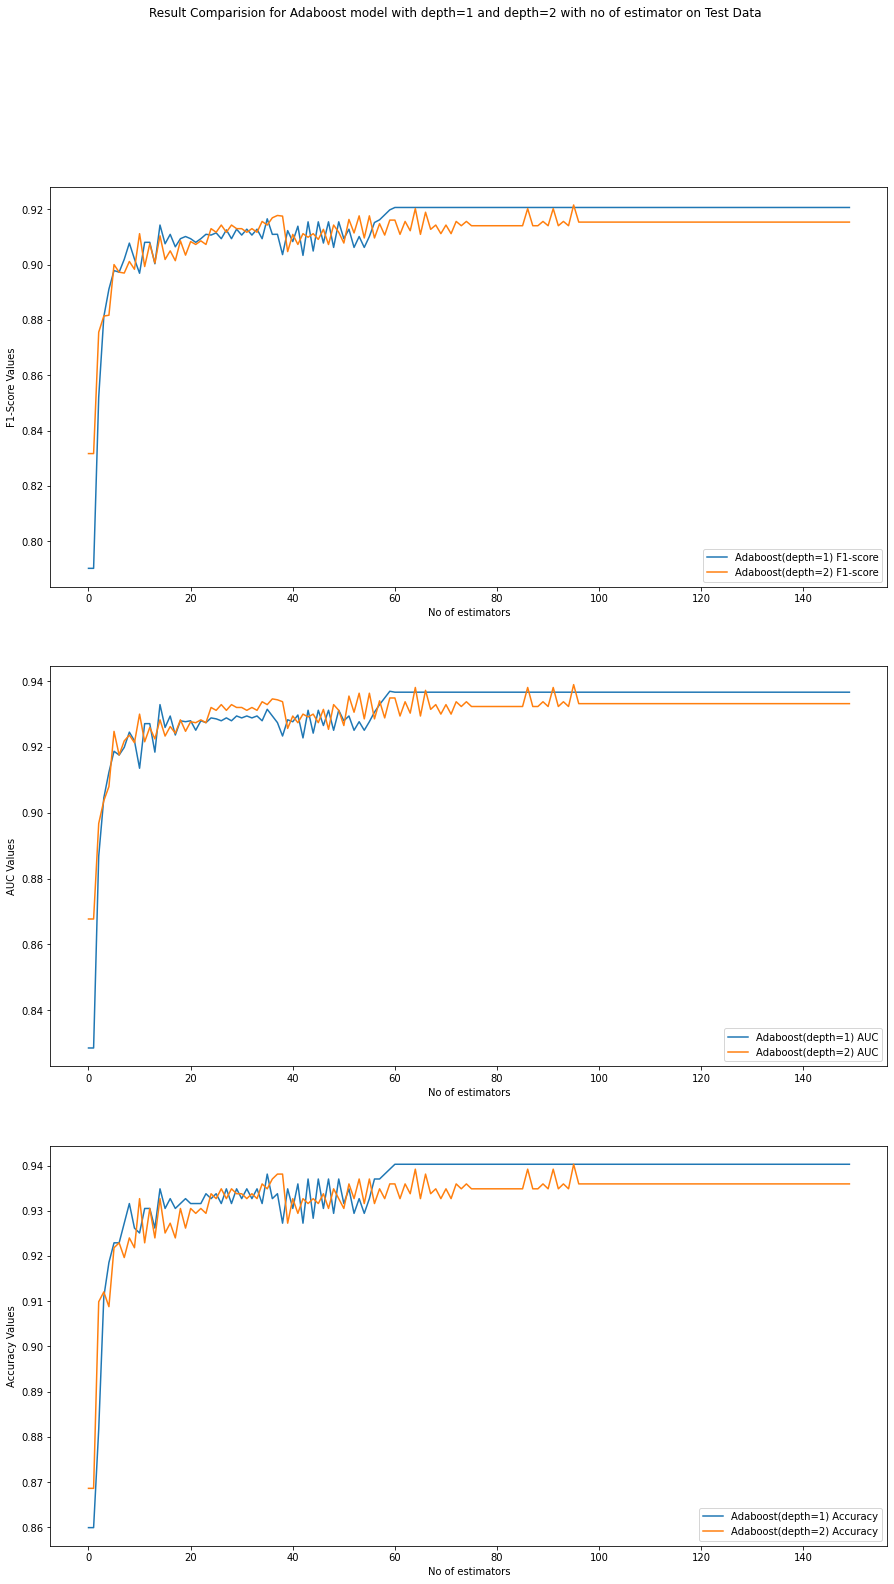

In [189]:

fig, axs = plt.subplots(3,figsize=(15,25))
fig.suptitle('Result Comparision for Adaboost model with depth=1 and depth=2 with no of estimator on Test Data')
axs[0].plot(range(n_clf), test_f1_m1, label = "Adaboost(depth=1) F1-score") 
axs[1].plot(range(n_clf),test_auc_m1, label = "Adaboost(depth=1) AUC")
axs[2].plot(range(n_clf),test_acc_m1, label = "Adaboost(depth=1) Accuracy")
axs[0].plot(range(n_clf), test_f1_m2, label = "Adaboost(depth=2) F1-score") 
axs[1].plot(range(n_clf),test_auc_m2, label = "Adaboost(depth=2) AUC")
axs[2].plot(range(n_clf),test_acc_m2, label = "Adaboost(depth=2) Accuracy")
axs[0].set_xlabel('No of estimators')
axs[1].set_xlabel('No of estimators')
axs[2].set_xlabel('No of estimators')
axs[0].set_ylabel('F1-Score Values')
axs[1].set_ylabel('AUC Values')
axs[2].set_ylabel('Accuracy Values')
axs[0].legend(loc=4)
axs[1].legend(loc=4)
axs[2].legend(loc=4)
plt.show()